# Cliff Walking - Comparison of Q-learning and SARSA

In [1]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm.notebook import trange

%matplotlib widget

## Agent
- $\varepsilon$-greedy policy
- learning paradigms or update rules:
    - Q-learning: $Q(s, a) = Q(s, a) + \alpha [r + \gamma \max_{a'} Q(s', a') - Q(s, a)]$ (off-policy)
    - SARSA: $Q(s, a) = Q(s, a) + \alpha [r + \gamma Q(s', \pi(s')) - Q(s, a)]$ (on-policy)

In [2]:
class CliffWalker:
    def __init__(self, alpha, epsilon, gamma, algorithm,environment):
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.environment = environment
        assert algorithm in ['Q-learning', 'SARSA']
        self.algorithm = algorithm

        self.q = defaultdict(lambda: np.zeros(environment.action_space.n))

    def reset(self):
        self.q = defaultdict(lambda: np.zeros(self.environment.action_space.n))

    def policy(self, state):
        if np.random.rand(1) < self.epsilon:
            action = self.exploratory_policy(state)
        else:
            action = self.exploiting_policy(state)
        return action

    def exploratory_policy(self, state):
        action = self.environment.action_space.sample()
        return action

    def exploiting_policy(self, state):
        action = np.argmax(self.q[state])
        return action

    def update(self, state, action, reward, new_state, new_action):
        q0 = self.q[state][action]
        if self.algorithm == 'Q-learning':
            new_action = self.exploiting_policy(new_state)
        q1 = self.q[new_state][new_action]
        delta = self.alpha * (reward + self.gamma * q1 - q0)
        self.q[state][action] += delta
        
    def epoch(self, train, render=False):
        state, _ = self.environment.reset()
        action = self.policy(state)
        if render:
            print(self.environment.render())

        total_reward = 0.0
        number_steps = 0
        done = False
        while not done:
            new_state, reward, terminated, truncated, _ = self.environment.step(action)
            if render:
                print(self.environment.render())
            if train:
                new_action = self.policy(new_state)
                self.update(state, action, reward, new_state, new_action)
            else:
                new_action = self.exploiting_policy(new_state)
            state = new_state
            action = new_action
            total_reward += reward
            number_steps += 1
            done = terminated or truncated
        return total_reward, number_steps

    def train(self, epochs):
        scores = {
            'reward': [],
            'steps': []
        }
        for _ in trange(epochs):
            total_reward, number_steps = self.epoch(train=True)
            scores['reward'].append(total_reward)
            scores['steps'].append(number_steps)
        return scores

In [3]:
env = gym.make('CliffWalking-v0', max_episode_steps=300)

In [4]:
alpha = 0.1
epsilon = 0.1
gamma = 0.9

sarsa_agent = CliffWalker(alpha, epsilon, gamma, 'SARSA', env)
q_agent = CliffWalker(alpha, epsilon, gamma, 'Q-learning', env)

## Training
- one agent per strategie
- identical hyperparameters

In [5]:
sarsa_agent.reset()
sarsa_scores = sarsa_agent.train(1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [6]:
q_agent.reset()
q_scores = q_agent.train(1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

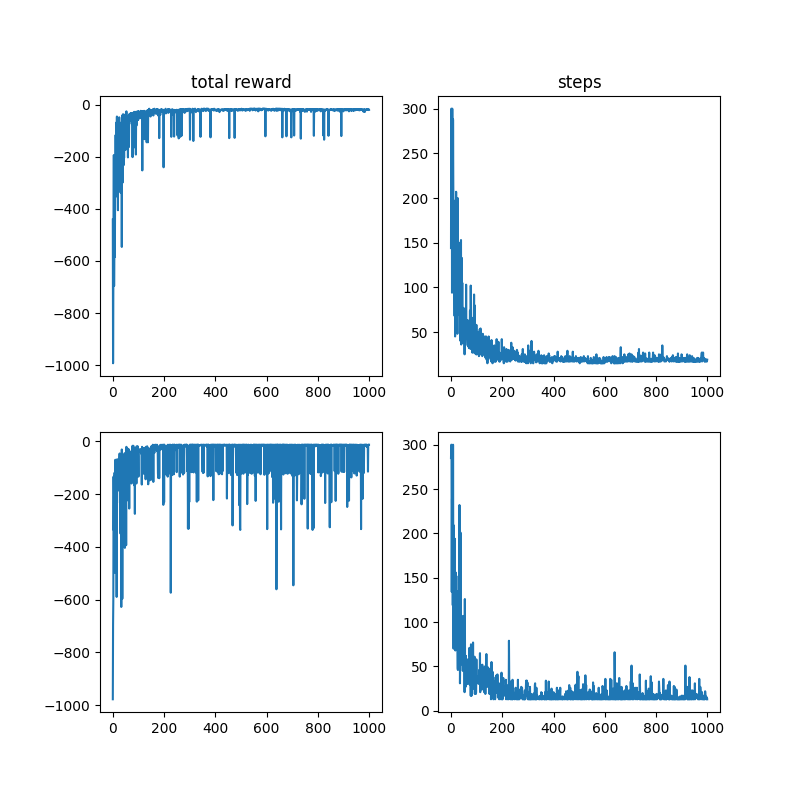

In [7]:
plt.figure(figsize=(8, 8))
plt.subplot(221)
plt.plot(sarsa_scores['reward'])
plt.title('total reward')
plt.subplot(222)
plt.plot(sarsa_scores['steps'])
plt.title('steps')
plt.subplot(223)
plt.plot(q_scores['reward'])
plt.subplot(224)
plt.plot(q_scores['steps'])
plt.show()

In [8]:
env.close()
env = gym.make('CliffWalking-v0', render_mode='ansi')
sarsa_agent.environment = env
q_agent.environment = env

In [9]:
sarsa_agent.epoch(train=False, render=True)

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T


o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T


o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T


x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T


o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T


o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T


o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T


o  o  

(-17.0, 17)

The SARSA agent takes a safer path, further away from the cliff, thereby accepting a slightly lower total reward than the shortest path would yield. This happens because during training, because of the exploration part of the policy, there is a non-zero probability for the agent to walk into the cliff even though it is not the optimal move. And since the SARSA update rule changes the previous state-action value according to the value of the action taken in the next state, the resulting state-action values that move the agent on a tile next to the cliff are rated lower than actions that lead to tiles farther away from the cliff.

In [10]:
q_agent.epoch(train=False, render=True)

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T


o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T


o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T


o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T


o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T


o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T


o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  x  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T


o  o  

(-13.0, 13)

The Q-learning agent takes the shortest path, directly along the cliff. Even though during training the agent can still end up in the cliff due to exploration, that will in the long run only influence the state-action value of actions that directly lead into the cliff since for the others, their value will be updated according to the optimal next step and not the actually next step.

In this deterministic environment the Q-learning agent is clearly superior since the caution of the SARSA agent is unnecessary, the caution he learns is not due to an uncertain environment but due to the direct influence of the internally uncertain decision-making onto the state-action value approximation.

In [11]:
env.close()